In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)

import mlflow
from datetime import datetime


import numpy as np
import pandas as pd

from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit

import shap

from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics
from utils.modelling_tools import (
    search_hyper_params_and_log,
    evaluate_model
)
from utils.metrics_by_quantile import MetricsByQuantile

In [5]:
RUN_NAME: str = '02-RF-hyperparams_tunning'

In [6]:
PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [7]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2022-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2022-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2022-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2022-08-01').date()

In [8]:
# set constants
COLS_TO_USE: List[str] = [
"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"SP_F2_33OptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"GEN11_SP_N_92OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"TRD_B_20OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"VM01_SP_VM2_24OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"VM01_SP_VM2_17OptBin",
"SP_B1_14OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"ND_ECC_06OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"E1_B_06OptBin",
"SP_I_67_01OptBin",
"GEN11_SP_K_80OptBin",
"SP_I_63_01OptBin",
"SP_B2_20OptBin",
"E4_Q_04OptBin",
"ND_ECC_04OptBin",
"VM08_SP_VM2_15OptBin",
"VAL_DELINQ_ACCSOptBin",
"ND_ERL_01OptBin",
"VM08_SP_VM2_20OptBin",
"EA1_D_02OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"E2_G_08OptBin",
"AFF_T_07_01OptBin",
"VM02_SP_VM1_18OptBin"
]

In [9]:
TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train+Val': 'black', 'Val': 'blue', 'Test': 'red', 'Train': 'orange'}
}

In [10]:
N_ITER: int = 100
RANDOM_SEED: int = 42
CONFIDENCE_LEVEL = 0.05

In [11]:
MODEL = RandomForestClassifier

In [12]:
PARAMS: Dict[str, Any] = dict(
    n_estimators=randint(100, 1000), 
    max_depth=[1, 2, 3], 
    min_samples_split=randint(50, 100),
    n_jobs=[-1],
    random_state=[RANDOM_SEED], 
    class_weight=['balanced', 'balanced_subsample'] 
)

In [13]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins.csv'), low_memory=False)

In [14]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2069


# Preprocessing

Convert dates to the corresponding types

In [15]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [16]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

# Split data

In [17]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [18]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

In [19]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test_same'].reset_index(drop=True), data_dict['df_test_same'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test_same'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [20]:
data_dict['df_test_same_sample'] = test_sample

# Run the experiment

## Feature selection with RF

In [21]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian][RF-feature-selection]")

<Experiment: artifact_location='mlflow-artifacts:/144656820801520540', creation_time=1716879635678, experiment_id='144656820801520540', last_update_time=1716879635678, lifecycle_stage='active', name='[Experian][RF-feature-selection]', tags={}>

In [22]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0==G, 1==B',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [23]:
print(experiment_description)


    'features': 47,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0==G, 1==B',
    'model': RandomForestClassifier,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2022-01-01, 2022-05-01),
    'test_period': [2022-05-01, 2022-08-01),



2024/05/30 11:32:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:32:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100


2024/05/30 11:32:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:32:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 2 / 100


2024/05/30 11:32:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:32:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100


2024/05/30 11:33:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:33:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 4 / 100


2024/05/30 11:33:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:33:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100


2024/05/30 11:33:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:33:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 6 / 100


2024/05/30 11:34:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:34:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 7 / 100


2024/05/30 11:34:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:34:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 8 / 100


2024/05/30 11:34:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:34:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 9 / 100


2024/05/30 11:35:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:35:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 10 / 100


2024/05/30 11:35:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:35:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 11 / 100


2024/05/30 11:35:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:35:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 12 / 100


2024/05/30 11:36:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:36:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100


2024/05/30 11:36:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:36:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 14 / 100


2024/05/30 11:37:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/30 11:37:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 15 / 100


2024/05/30 11:37:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:37:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 16 / 100


2024/05/30 11:37:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:37:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 17 / 100


2024/05/30 11:38:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:38:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 18 / 100


2024/05/30 11:38:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:38:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 19 / 100


2024/05/30 11:39:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:39:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 20 / 100


2024/05/30 11:39:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:39:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100


2024/05/30 11:39:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:39:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 22 / 100


2024/05/30 11:40:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:40:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 23 / 100


2024/05/30 11:40:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:40:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 24 / 100


2024/05/30 11:41:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:41:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 25 / 100


2024/05/30 11:41:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:41:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 26 / 100


2024/05/30 11:41:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:41:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 27 / 100


2024/05/30 11:42:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:42:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 28 / 100


2024/05/30 11:42:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:42:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/30 11:42:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:42:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100


2024/05/30 11:43:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:43:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 31 / 100


2024/05/30 11:43:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:43:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100


2024/05/30 11:44:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:44:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 33 / 100


2024/05/30 11:44:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:44:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100


2024/05/30 11:44:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:44:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 35 / 100


2024/05/30 11:45:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:45:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 36 / 100


2024/05/30 11:45:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:45:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 37 / 100


2024/05/30 11:45:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:45:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 38 / 100


2024/05/30 11:46:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:46:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 39 / 100


2024/05/30 11:46:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:46:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 40 / 100


2024/05/30 11:46:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:46:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100


2024/05/30 11:47:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:47:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 42 / 100


2024/05/30 11:47:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:47:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 43 / 100


2024/05/30 11:48:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:48:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 44 / 100


2024/05/30 11:48:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:48:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 45 / 100


2024/05/30 11:48:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:48:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 46 / 100


2024/05/30 11:49:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 11:49:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 47 / 100


2024/05/30 11:49:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:49:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100


2024/05/30 11:49:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:49:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 49 / 100


2024/05/30 11:50:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:50:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100


2024/05/30 11:50:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:50:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 51 / 100


2024/05/30 11:50:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:50:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 52 / 100


2024/05/30 11:51:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:51:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 53 / 100


2024/05/30 11:51:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:51:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 54 / 100


2024/05/30 11:51:48 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:51:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 55 / 100


2024/05/30 11:52:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:52:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 56 / 100


2024/05/30 11:52:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:52:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 57 / 100


2024/05/30 11:52:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:52:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/05/30 11:53:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:53:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 59 / 100


2024/05/30 11:53:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:53:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100


2024/05/30 11:53:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:53:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 61 / 100


2024/05/30 11:54:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/30 11:54:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 62 / 100


2024/05/30 11:54:25 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:54:25 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 63 / 100


2024/05/30 11:54:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:54:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 64 / 100


2024/05/30 11:55:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:55:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 65 / 100


2024/05/30 11:55:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:55:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 66 / 100


2024/05/30 11:55:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:55:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 67 / 100


2024/05/30 11:56:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:56:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100


2024/05/30 11:56:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:56:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 69 / 100


2024/05/30 11:56:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:56:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 70 / 100


2024/05/30 11:57:19 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:57:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 71 / 100


2024/05/30 11:57:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:57:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 72 / 100


2024/05/30 11:58:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:58:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 73 / 100


2024/05/30 11:58:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:58:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100


2024/05/30 11:59:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:59:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 75 / 100


2024/05/30 11:59:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:59:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 76 / 100


2024/05/30 11:59:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 11:59:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 77 / 100


2024/05/30 12:00:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:00:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 78 / 100


2024/05/30 12:00:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:00:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100


2024/05/30 12:00:53 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:00:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 80 / 100


2024/05/30 12:01:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:01:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 81 / 100


2024/05/30 12:01:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:01:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100


2024/05/30 12:01:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:01:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 83 / 100


2024/05/30 12:02:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:02:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 84 / 100


2024/05/30 12:02:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:02:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 85 / 100


2024/05/30 12:02:53 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:02:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 86 / 100


2024/05/30 12:03:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:03:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 87 / 100


2024/05/30 12:03:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:03:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/30 12:03:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:03:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100


2024/05/30 12:04:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:04:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 90 / 100


2024/05/30 12:04:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:04:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 91 / 100


2024/05/30 12:04:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:04:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 92 / 100


2024/05/30 12:04:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:04:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100


2024/05/30 12:05:19 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:05:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 94 / 100


2024/05/30 12:05:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:05:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 95 / 100


2024/05/30 12:05:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:05:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 96 / 100


2024/05/30 12:06:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:06:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 97 / 100


2024/05/30 12:06:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:06:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/05/30 12:06:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:06:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 99 / 100


2024/05/30 12:07:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:07:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 100 / 100


2024/05/30 12:07:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:07:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'n_estimators': 152, 'max_depth': 2, 'min_samples_split': 74, 'n_jobs': -1, 'random_state': 42, 'class_weight': 'balanced_subsample'}
Val-PR_AUC:  0.16590326463737054
Val-GINI:  0.6843310865805496
Not saved
Test-PR_AUC 0.12694314216826064
Test-Gini 0.6065473808571045


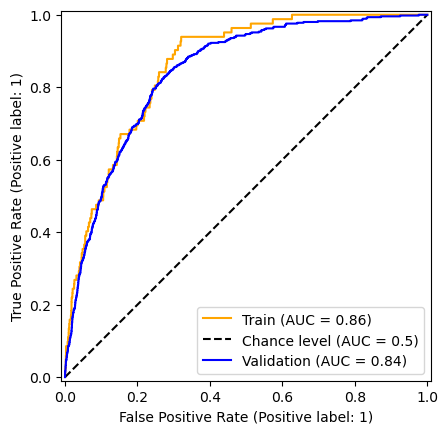

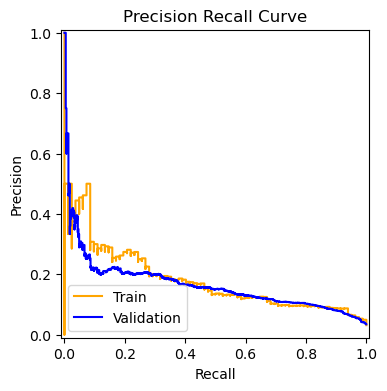

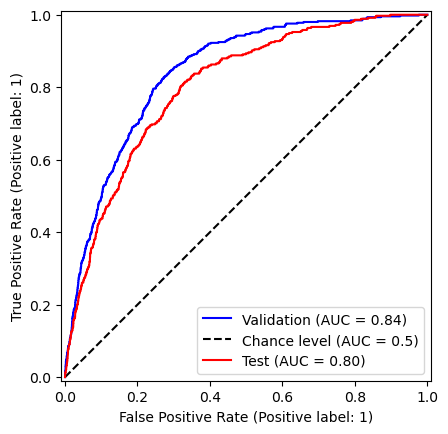

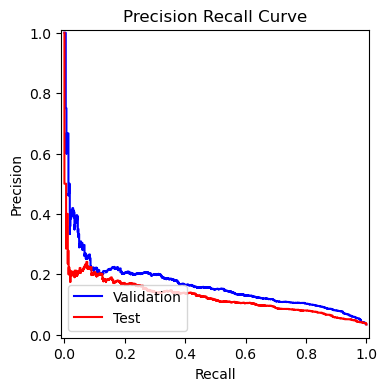

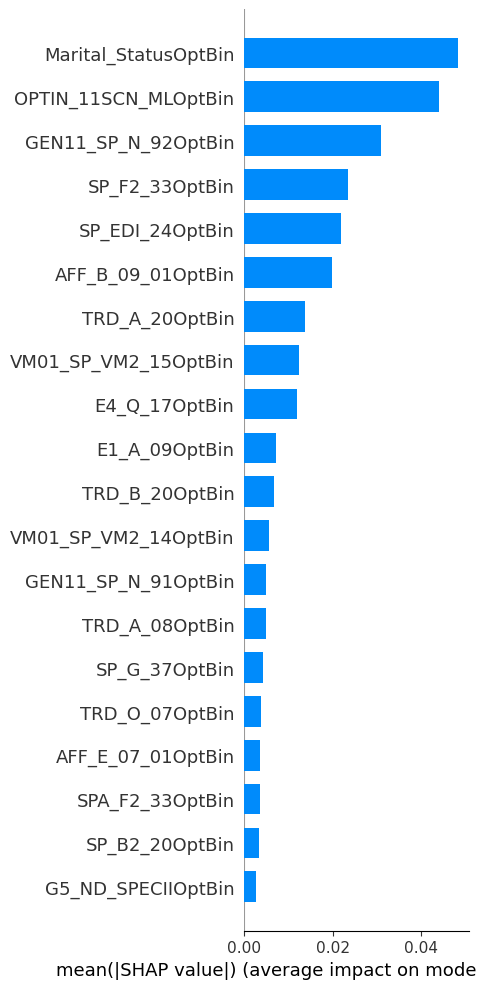

2024/05/30 12:08:33 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/30 12:08:33 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [24]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=None,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH,
        model_type='RF',
        normalize=False,
        shap_explainer=shap.TreeExplainer
    )

In [25]:
df_metrics, df_imp, data_dict, model_obj, std_scaler = res

### RF's quality

#### Feature importance, SHAP

In [29]:
# features with 0 importance
for col in COLS_TO_USE:
    if col not in df_imp[df_imp['Importance(SHAP)'] == 0].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"SP_F2_33OptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"GEN11_SP_N_92OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"TRD_B_20OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"VM01_SP_VM2_24OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"VM01_SP_VM2_17OptBin",
"SP_B1_14OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"ND_ECC_06OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"SP_I_67_01OptBin",
"SP_I_63_01OptBin",
"SP_B2_20OptBin",
"E4_Q_04OptBin",
"ND_ECC_04OptBin",
"VAL_DELINQ_ACCSOptBin",
"ND_ERL_01OptBin",
"EA1_D_02OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"AFF_T_07_01OptBin",


In [26]:
df_imp.sort_values('Importance(SHAP)', ascending=False)

,Feature,Importance(SHAP),"Importance(SHAP, %)"
2,Marital_StatusOptBin,0.048345,16.258423
0,OPTIN_11SCN_MLOptBin,0.043925,14.771998
8,GEN11_SP_N_92OptBin,0.031015,10.430365
3,SP_F2_33OptBin,0.023428,7.878988
9,SP_EDI_24OptBin,0.021937,7.377392
4,AFF_B_09_01OptBin,0.019875,6.684073
5,TRD_A_20OptBin,0.013731,4.617831
7,VM01_SP_VM2_15OptBin,0.012355,4.155109
11,E4_Q_17OptBin,0.011976,4.027482
20,E1_A_09OptBin,0.007085,2.382547


In [27]:
# features with 0 importance
df_imp[df_imp['Importance(SHAP)'] == 0]

,Feature,Importance(SHAP),"Importance(SHAP, %)"
30,E1_B_06OptBin,0.0,0.0
32,GEN11_SP_K_80OptBin,0.0,0.0
37,VM08_SP_VM2_15OptBin,0.0,0.0
40,VM08_SP_VM2_20OptBin,0.0,0.0
44,E2_G_08OptBin,0.0,0.0
46,VM02_SP_VM1_18OptBin,0.0,0.0


In [28]:
# features with low importance
df_imp[df_imp['Importance(SHAP, %)'] < 1]

,Feature,Importance(SHAP),"Importance(SHAP, %)"
1,G5_ND_SPECIIOptBin,0.002667,0.896929
12,TRD_C_07OptBin,0.000586,0.196994
14,SP_B2_18OptBin,0.002085,0.701040
17,VM01_SP_VM2_24OptBin,0.002424,0.815127
18,SP_G_38OptBin,0.002311,0.777292
19,TRD_O_05OptBin,0.001217,0.409199
22,ND_INC_03OptBin,0.001841,0.618971
23,VM01_SP_VM2_17OptBin,0.001452,0.488175
24,SP_B1_14OptBin,0.000547,0.183961
26,GEN11_SP_EDI_07OptBin,0.001028,0.345856


#### GINI, AU PRC

##### Test-same

In [30]:
std_scaler

In [31]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.12694314216826064
Test-Gini 0.6065473808571045


##### Test-full

In [32]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.11217196262463522
Test-Gini 0.5910935071405401


#### Outcomes distributions

In [34]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    data_dict['df_test'][COLS_TO_USE]
)[:, 1]

##### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

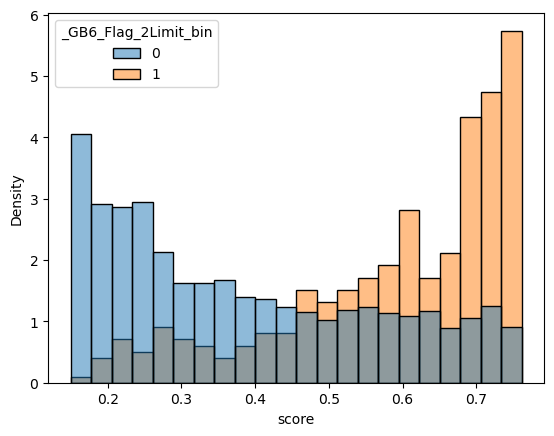

In [35]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

##### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

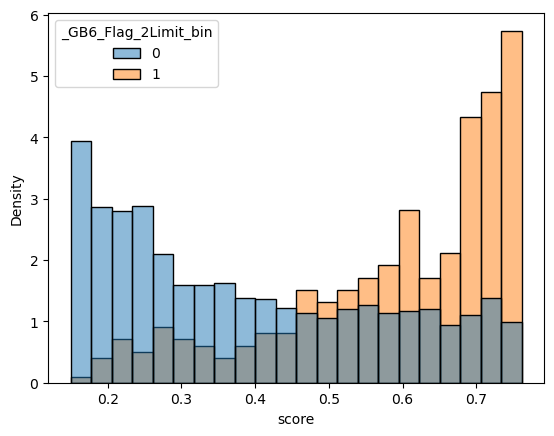

In [36]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

#### Precision, Recall By Quantile

##### Test-same

In [37]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.36,0.36,38,7,7,"(0.755, 0.762]",199,18.421053,1.960784,18.421053,1.960784,0.755--0.762
1,0.64,1.00,68,16,23,"(0.75, 0.755]",198,21.698113,6.442577,23.529412,4.481793,0.75--0.755
2,0.42,1.42,45,9,32,"(0.746, 0.75]",197,21.192053,8.963585,20.000000,2.521008,0.746--0.75
3,0.51,1.93,54,9,41,"(0.742, 0.746]",196,20.000000,11.484594,16.666667,2.521008,0.742--0.746
4,0.46,2.39,49,5,46,"(0.739, 0.742]",195,18.110236,12.885154,10.204082,1.400560,0.739--0.742
5,0.48,2.86,51,10,56,"(0.734, 0.739]",194,18.360656,15.686275,19.607843,2.801120,0.734--0.739
6,0.54,3.41,58,8,64,"(0.73, 0.734]",193,17.630854,17.927171,13.793103,2.240896,0.73--0.734
7,0.54,3.94,57,7,71,"(0.726, 0.73]",192,16.904762,19.887955,12.280702,1.960784,0.726--0.73
8,0.42,4.37,45,8,79,"(0.723, 0.726]",191,16.989247,22.128852,17.777778,2.240896,0.723--0.726
9,0.61,4.98,65,7,86,"(0.719, 0.723]",190,16.226415,24.089636,10.769231,1.960784,0.719--0.723


##### Test-full

In [38]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.41,0.41,46,7,7,"(0.755, 0.762]",200,15.217391,1.960784,15.217391,1.960784,0.755--0.762
1,0.51,0.92,58,12,19,"(0.751, 0.755]",199,18.269231,5.322129,20.689655,3.361345,0.751--0.755
2,0.52,1.44,59,13,32,"(0.747, 0.751]",198,19.631902,8.963585,22.033898,3.641457,0.747--0.751
3,0.51,1.96,58,6,38,"(0.743, 0.747]",197,17.194570,10.644258,10.344828,1.680672,0.743--0.747
4,0.46,2.42,52,7,45,"(0.74, 0.743]",196,16.483516,12.605042,13.461538,1.960784,0.74--0.743
5,0.53,2.95,60,9,54,"(0.735, 0.74]",195,16.216216,15.126050,15.000000,2.521008,0.735--0.74
6,0.50,3.44,56,5,59,"(0.731, 0.735]",194,15.167095,16.526611,8.928571,1.400560,0.731--0.735
7,0.42,3.87,48,8,67,"(0.728, 0.731]",193,15.331808,18.767507,16.666667,2.240896,0.728--0.731
8,0.50,4.36,56,6,73,"(0.725, 0.728]",192,14.807302,20.448179,10.714286,1.680672,0.725--0.728
9,0.58,4.95,66,10,83,"(0.721, 0.725]",191,14.847943,23.249300,15.151515,2.801120,0.721--0.725
